**Load Module**

In [1]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import torchvision.models as models
from utility.early_stopping import EarlyStopping
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report

**Seed Setting**

In [2]:
random.seed(0)

**Device Setting**

In [3]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Set Hyperparameters**

In [4]:
batch_size = 128
num_epochs = 1
learning_rate = 0.001
momentum = 0.9

# Data Preprocessing

In [5]:
train_val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4), 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

**Splitting the training data**

In [6]:
train_val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_val_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# train 데이터를 train/val로 나누기
num_train = len(train_val_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # validation 데이터를 20%로 설정

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

**Define Dataloader**

In [8]:
train_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

**Training Loop**

In [9]:
from models import resnet

print("use:", device)

# 모델 초기화
# net = Net()
net = resnet.resnet18()

# 모델을 GPU로 이동
net.to(device)

print(summary(net, (3,224,224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14       

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}]


**Model Train**

In [11]:
writer = SummaryWriter("./runs/resnet_18/tensorboard")

In [12]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [13]:
# 모델 학습 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            labels = labels.type(torch.LongTensor).to(device)  # CPU에서 long type tensor로 변환
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 30번째 배치마다 상태 출력
            if (batch_idx + 1) % 30 == 0:
                print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # Epoch당 평균 손실 계산 및 출력
        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early Stopping 체크
        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

**Model Test**

In [14]:
# 모델 평가 및 테스트 함수 (superclass 예측 포함)
def test_model(model, testloader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 예측
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)

            # 예측 결과 저장 및 정확도 계산
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

            # TensorBoard에 테스트 손실 및 정확도 기록
            writer.add_scalar("Test Loss", test_loss / len(testloader.dataset), epoch)
            writer.add_scalar("Test Accuracy", correct / len(testloader.dataset), epoch)

    # 평균 손실 및 정확도 계산
    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset)
    # test_accuracies.append(accuracy)

    return test_loss, accuracy

**Per-Epoch Training**

In [15]:
for epoch in tqdm(range(1, num_epochs + 1)):
    train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
    test_loss, test_accuracy = test_model(net, test_loader, criterion, epoch)
    writer.add_scalar("Test Loss", test_loss, epoch)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch)
    print(f"Processing Result = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")
    writer.close()

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Batch [30/313], Loss: 4.6404
Batch [60/313], Loss: 4.4032
Batch [90/313], Loss: 4.2177
Batch [120/313], Loss: 4.0439
Batch [150/313], Loss: 4.1205
Batch [180/313], Loss: 3.9525
Batch [210/313], Loss: 4.0081
Batch [240/313], Loss: 3.7878
Batch [270/313], Loss: 3.9274
Batch [300/313], Loss: 3.8667
Epoch [1/1], Loss: 3.2778
Validation loss decreased (inf --> 3.277763).  Saving model ...


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.73s/it]

Processing Result = Epoch : 1   Loss : 3.7533269050598146   Accuracy : 0.1192


**Result**

In [16]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

 Result of ResNet = Epoch : 1   Loss : 3.7533269050598146   Accuracy : 0.1192


In [17]:
# torch.save(net, "resnet_18.pt")

**Test**

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개 테스트 이미지에서 모델 정확도: %.2f %%' % (
    100 * correct / total))

10000개 테스트 이미지에서 모델 정확도: 11.92 %


**Visualization of average loss**

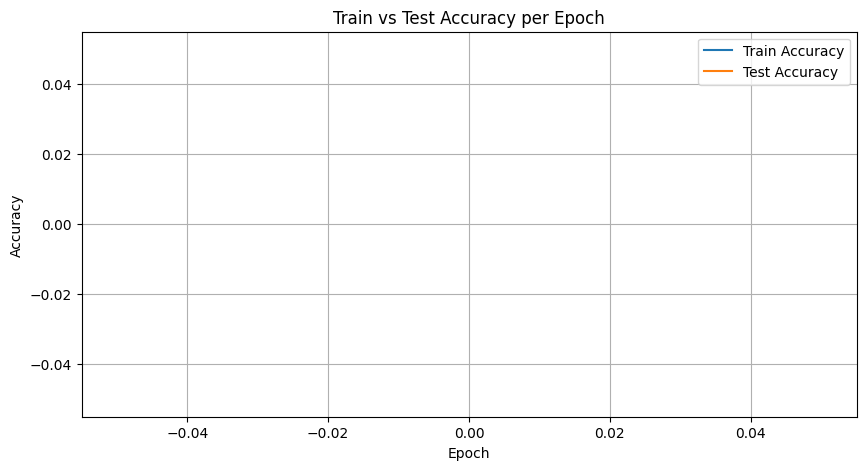

In [19]:
train_accuracies = []
test_accuracies = []

# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

**Top-1 Accuracy**

In [20]:
def calculate_top1_accuracy(model, device, data_loader):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # # 각 샘플에 대한 예측 결과와 실제 레이블 출력
            # for i in range(data.size(0)):
            #     print(f"Sample {i + 1}: Predicted = {predicted[i].item()}, Actual = {target[i].item()}")

    top1_accuracy = 100 * correct / total
    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")

In [21]:
# 모델 훈련 후 검증 데이터셋에 대한 Top-1 정확도 계산 및 출력
calculate_top1_accuracy(net, device, val_loader)

Top-1 Accuracy: 13.16%


**Top-5 Accuracy**

In [22]:
def calculate_and_print_top5_accuracy(model, device, data_loader):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Top-5 예측 결과 가져오기
            _, predicted_top5 = torch.topk(outputs, 5, dim=1)
            total += target.size(0)
            
            # 예측된 Top-5 내에 실제 레이블이 있는지 확인
            correct += (predicted_top5 == target.view(-1, 1)).sum().item()

    top5_accuracy = 100 * correct / total
    print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

In [29]:
calculate_and_print_top5_accuracy(net, device, test_loader)

Top-5 Accuracy: 34.87%


**Super Class Accuracy**

In [24]:
fine_to_superclass = {
    # aquatic mammals
    4: 0, 30: 0, 55: 0, 72: 0, 95: 0,
    
    # fish
    1: 1, 32: 1, 67: 1, 73: 1, 91: 1,
    
    # flowers
    54: 2, 62: 2, 70: 2, 82: 2, 92: 2,
    
    # food containers
    9: 3, 10: 3, 16: 3, 28: 3, 61: 3,
    
    # fruit and vegetables
    0: 4, 51: 4, 53: 4, 57: 4, 83: 4,
    
    # household electrical devices
    22: 5, 39: 5, 40: 5, 86: 5, 87: 5,
    
    # household furniture
    5: 6, 20: 6, 25: 6, 84: 6, 94: 6,
    
    # insects
    6: 7, 7: 7, 14: 7, 18: 7, 24: 7,
    
    # large carnivores
    3: 8, 42: 8, 43: 8, 88: 8, 97: 8,
    
    # large man-made outdoor things
    12: 9, 17: 9, 37: 9, 68: 9, 76: 9,
    
    # large natural outdoor scenes
    23: 10, 33: 10, 49: 10, 60: 10, 71: 10,
    
    # large omnivores and herbivores
    15: 11, 19: 11, 21: 11, 31: 11, 38: 11,
    
    # medium-sized mammals
    34: 12, 63: 12, 64: 12, 66: 12, 75: 12,
    
    # non-insect invertebrates
    26: 13, 45: 13, 77: 13, 79: 13, 99: 13,
    
    # people
    2: 14, 11: 14, 35: 14, 46: 14, 98: 14,
    
    # reptiles
    27: 15, 29: 15, 44: 15, 78: 15, 93: 15,
    
    # small mammals
    36: 16, 50: 16, 65: 16, 74: 16, 80: 16,
    
    # trees
    47: 17, 52: 17, 56: 17, 59: 17, 96: 17,
    
    # vehicles 1
    8: 18, 13: 18, 48: 18, 58: 18, 90: 18,
    
    # vehicles 2
    41: 19, 69: 19, 81: 19, 85: 19, 89: 19
}

In [25]:
def superclass_accuracy(model, device, data_loader, k=1, super=False):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            _, predicted = torch.topk(outputs, k, dim=1)

            if super:  # 슈퍼클래스 기준으로 계산
                # 세부 클래스를 슈퍼클래스로 변환
                target_super = torch.tensor([fine_to_superclass[t.item()] for t in target], device=device)
                predicted_super = torch.tensor([fine_to_superclass[p.item()] for p in predicted.view(-1)], device=device).view_as(predicted)                
                correct += (predicted_super == target_super.view(-1, 1)).any(dim=1).sum().item()
            else:  # 세부 클래스 기준으로 계산
                correct += (predicted == target.view(-1, 1)).any(dim=1).sum().item()
            
            total += target.size(0)

    accuracy = 100 * correct / total
    
    if not super:
        print(f"Top-{k} Accuracy: {accuracy:.2f}%")
    else:
        print(f"Super-{k} Accuracy: {accuracy:.2f}%")

In [34]:
superclass_accuracy(net, device, test_loader, 1, True)

Super-1 Accuracy: 22.54%


**Data Analysis**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./runs/resnet_18/tensorboard --port=8203 --host=0.0.0.0

**Classes**

In [ ]:
classes = train_val_data.classes
coarse_classes = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 
    'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 
    'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 
    'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

In [ ]:
print(len(classes), len(coarse_classes))

**Confusion Matrix**

In [ ]:
# y_pred = []
# y_true = []

# # iterate over test data
# for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    
#     #print('iter val', i)
#     x = x.to(device)
#     y = y.to(device)
#     z = net(x)
#     _, yhat = torch.max(z, 1)
#     pred = yhat.data.cpu().numpy()
#     y_pred.extend(pred) # Save Prediction

#     labels = y.data.cpu().numpy()
#     y_true.extend(labels) # Save Truth

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (128,70))
# sns.heatmap(df_cm, annot=True)
# plt.title('Confusion Matrix of ResNet (CIFAR100)')
# plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100.jpg')

In [ ]:
# print(f" Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

**Confusion Matrix - Coarse**

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    
    # Save Prediction and convert to superclasses
    pred = yhat.data.cpu().numpy()
    super_pred = [fine_to_superclass[p] for p in pred]
    y_pred.extend(super_pred)
    
    # Save Truth and convert to superclasses
    labels = y.data.cpu().numpy()
    super_labels = [fine_to_superclass[l] for l in labels]
    y_true.extend(super_labels)

# Build confusion matrix for superclasses
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Normalize confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=coarse_classes,
                     columns=coarse_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix of ResNet (CIFAR-100 Superclass)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100_superclass.jpg')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

**Classification Report**

In [ ]:
print(f"Super Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")